# **Import required Libraries!**

in the below block we're importing the libraries that we will use in the further codes in this Question!

In [1]:
import os, gzip, torch
import torch.nn as nn
import numpy as np
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision.utils as vutils

import imageio
from torch.utils.data import DataLoader

import torch, time, os, pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
# from skimage import color
from skimage import img_as_ubyte

# **Find GPU Model**

in the code below we're trying to find the GPU model that Google Colab is using!

this line of code is handy and useful for us to findout we're using a proper GPU  to train our model fast as possible!

In [2]:
cur_device = torch.cuda.current_device()
device_count = torch.cuda.device_count()
print("**************************************")
print("Device Count :=> ", device_count)
print("==================================")
device_name = torch.cuda.get_device_name(0)
print("==================================")
print("Device Name :=> ", device_name)
print("**************************************")
print("######################################")
cuda_available = torch.cuda.is_available()
print("is CUDA Available :=> ", cuda_available)
print("######################################")

**************************************
Device Count :=>  1
Device Name :=>  Tesla P100-PCIE-16GB
**************************************
######################################
is CUDA Available :=>  True
######################################


# **Prepare and Import the Dataset**

in the code below we're importing and dataset CIFAR10 first!
and after that we're getting it ready for using in future! and we will use this dataset in the dataloader and getting it ready for training in the model!


we in this Question take a different approach to import the dataset we build the dataset as a class and we use it in out training Process!

in the first 3 lines of the class (2 to 5) we're specifying the transformations that we want to apply them to our dataset!

after thet ij line 7 to 9 we're using the dataloader to load our dataset with specified batch_sizes and etc...

In [3]:
def DatasetDataLoader(dataset, input_size, batch_size, split='train'):
    transform = transforms.Compose([transforms.Resize((input_size, input_size)), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                    ])
    if dataset == 'cifar10':
        data_loader = DataLoader(
            datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
            batch_size=batch_size, shuffle=True)
    return data_loader

# **Setting up the Device**

in here we're setting the Hardware in which our dataset we want to be trained on! if we have GPU we will set it to ran on GPU otherwise it will ran on CPU!

if we prefer to run the model on GPU we will simply turn the ngpu to 0!

In [4]:
# Number of GPUs available. Use 0 for CPU mode.
if cuda_available is True:
    ngpu = 1
else:
    ngpu = 0
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Build a Sample from our DataSet

in the block code below we're trying to build a sample of our CIFAR10 dataset from the class of dataset that we build in the previous code block!

Files already downloaded and verified


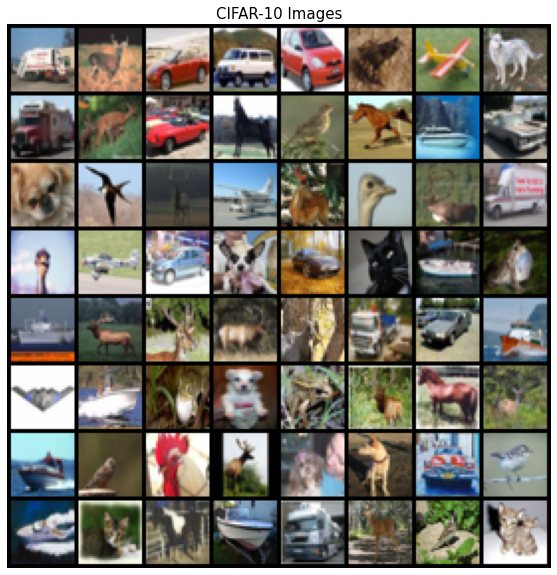

In [5]:
dataloader = DatasetDataLoader(dataset='cifar10', input_size=32, batch_size=128)
# Plot same training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("CIFAR-10 Images", fontsize=15)
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

# **Utility Part!**

in the three next code blocks we have some utility functions that we will use them for things like plot results and save images and etc...

# Print Network

the code block below and the function __print_network__ as it is obvious from it's name it's for printing the networks that we have builded like Generator and Discriminator!

In [6]:
def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

# Save Image Part

in these 3 functions in code block below we're trying to save images that we have in the training loop like images the we get in each epoch from our results and etc...

we use the imageio library in python libraries to save images!

merge function is for building the block of images and after that we will save it!

In [7]:
def save_images(images, size, image_path):
    return imsave(images, size, image_path)

def imsave(images, size, path):
    image = np.squeeze(merge(images, size))#.astype(np.uint8)
    image = img_as_ubyte(image)
    imageio.imwrite(path, image)
    return imageio.imwrite(path, image)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')

# Generate GIF

in this function below named __generate_animation()__ we build a gif from the results in each epoch that we get and after that we save this generated gif!

In [8]:
def generate_animation(path, num):
    images = []
    for e in range(num):
        img_name = path + '_epoch%03d' % (e+1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(path + '_generate_animation.gif', images, fps=5)

# Plot Loss

this function below named __loss_plot()__ is for plotting the Losses that we get in each iteration that we have saved it in a python List and now we're going to plot these Losses!

In [9]:
def loss_plot(history, path='Train_hist.png', model_name=''):
    x = range(len(history['D_loss']))

    y1 = history['D_loss']
    y2 = history['G_loss']
    plt.figure(figsize=(25, 7))
    plt.title("Generator and Discriminator Loss During Training", fontsize=17)
    plt.plot(x, y1, label='Discriminator Loss')
    plt.plot(x, y2, label='Generator Loss')

    plt.xlabel('iterations')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')

    plt.savefig(path)

    plt.close()

# Initialize Weights

this function below named __initialize_weights__ is for initializing weights to our generator and discriminator and we're using it while building them!

In [10]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)


# **Generator Part**

in the code block below we're building the Generator part for ACGAN!

in the first lines (line 3 to 7) we're specifying the parameters for the discriminator!

as you can see here in Generator we give like CGAN the class number to the network!

------------------------

in line 10 to 16: we're building a sequential that contains of dense layers with ReLU activation function and also with Batch Normalization!

-------------------

in line 17 to 23: in these lines we're also building a sequential but this time it's consist of DeConvolution layer (2 conv) also with ReLU activation function and Batch Normalization!

in the Last part we have a Tanh() activation that will set our images between 1 and -1 for better normalization!

-------------------

in line 24 we're setting an initialization for the weights in this model!

-----------------

in the forward part no we send the input (noise) with the label that we want to generate and now we will apply these to the two sequential parts that mentioned before!


In [11]:
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, input_size=32, class_num=10):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim + self.class_num, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(True),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=self.output_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input, label):
        x = torch.cat([input, label], 1)
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

# **Discriminator Part**

in this part in first lines (3 to 7) we're setting the parameters for Discriminator!

after that in line 9 to 15 we're using a sequential with Convolution layers and Leaky ReLU activation functions and also with using Batch Normalization!

---------------

after that in line 16 to 24 we have two seperate sequentials with dense layers activation functions in here are Leaky ReLU and after that sigmoid!

----------------

after that in lines 27 to 27 we have another dense layer for classification which is the Characteristic of ACGAN and the difference between CGAN and ACGAN!

------------
also in line 30 till end that is the forward part we can see that we give the input as parameter and the discriminator uses the mentioned layers and classifies that!

In [12]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32, class_num=10):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=self.input_dim, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
        )
        self.dc = nn.Sequential(
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )
        self.cl = nn.Sequential(
            nn.Linear(1024, self.class_num),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc1(x)
        d = self.dc(x)
        c = self.cl(x)

        return d, c

# **ACGAN MAIN**

here is the main ACGAN part that the training and Hyperparameters mostly set here!

in the first function named __init__ we firstly specify the parameters for the training and etc. after that in line 19 and 20 we're setting and using the dataset and load our data with data loader and using the _DatasetDataLoader__ function that i have mentioned before!

in lines 23 & 24 we're setting and using the Generator & Discriminator!

after that in line 25 & 26 we specify the optimizers that we want for our Discriminator and Generator Model to train on it!

after that is the important part and the difference between this Network (ACGAN) and CGAN in line 28 till 35 we're first set and send our data to GPU! after that we set the Loss function!

as you can see in here we specify 2 Loss functions one __BCELoss__ like before for training 2 D & G models and a CrossEntropy Loss for the classification part that ACGAN has!

after that as i mentioned completly in CGAN documents and Notebook is for generating noise and etc..

---------------------


now we go to the __train__ function in this class!!!

in the train function everything is the same as CGAN THE only difference is that in here as you can see in lines 95 till 104 we're using 2 loss functions for the discriminator BCE loss is same as before and we use CrossEntropy Loss in here to measure Loss in classification that we have in ACGAN discriminator!

all the other code is same as CGAN and there is no need for further explaination!

---------------

the save, load and visualize_results functions are exactly the same and there is no more need to explain for more info read the CGAN notebook's this section!



In [13]:
!class ACGAN(object):
    def __init__(self, epoch, batch_size, save_dir, result_dir, dataset, log_dir, gpu_mode, gan_type, input_size, beta1=0.5, beta2=0.999, lrG=0.0002, lrD=0.0002):
        # parameters
        self.epoch = epoch
        self.sample_num = 100
        self.batch_size = batch_size
        self.save_dir = save_dir
        self.result_dir = result_dir
        self.dataset = dataset
        self.log_dir = log_dir
        self.gpu_mode = gpu_mode
        self.model_name = gan_type
        self.input_size = input_size
        self.z_dim = 62
        self.class_num = 10
        self.sample_num = self.class_num ** 2

        # load dataset
        self.data_loader = DatasetDataLoader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks INITIALIZATION
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=lrG, betas=(beta1, beta2))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=lrD, betas=(beta1, beta2))

        if self.gpu_mode:
            self.G.cuda()
            self.D.cuda()
            self.BCE_loss = nn.BCELoss().cuda()
            self.CE_loss = nn.CrossEntropyLoss().cuda()
        else:
            self.BCE_loss = nn.BCELoss()
            self.CE_loss = nn.CrossEntropyLoss()

        print('---------- Networks architecture -------------')
        print_network(self.G)
        print_network(self.D)
        print('-----------------------------------------------')

        # fixed noise & condition
        self.sample_z_ = torch.zeros((self.sample_num, self.z_dim))
        for i in range(self.class_num):
            self.sample_z_[i*self.class_num] = torch.rand(1, self.z_dim)
            for j in range(1, self.class_num):
                self.sample_z_[i*self.class_num + j] = self.sample_z_[i*self.class_num]

        temp = torch.zeros((self.class_num, 1))
        for i in range(self.class_num):
            temp[i, 0] = i

        temp_y = torch.zeros((self.sample_num, 1))
        for i in range(self.class_num):
            temp_y[i*self.class_num: (i+1)*self.class_num] = temp

        self.sample_y_ = torch.zeros((self.sample_num, self.class_num)).scatter_(1, temp_y.type(torch.LongTensor), 1)
        if self.gpu_mode:
            self.sample_z_, self.sample_y_ = self.sample_z_.cuda(), self.sample_y_.cuda()

    def train(self):
        img_list = []
        G_losses = []
        D_losses = []
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        if self.gpu_mode:
            self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            print("|==================================================================================================|")
            print("|******************************************* Epoch:=> {0} *******************************************|".format(epoch+1))
            print("|==================================================================================================|")
            epoch_start_time = time.time()
            for iter, (x_, y_) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                z_ = torch.rand((self.batch_size, self.z_dim))
                y_vec_ = torch.zeros((self.batch_size, self.class_num)).scatter_(1, y_.type(torch.LongTensor).unsqueeze(1), 1)
                if self.gpu_mode:
                    x_, z_, y_vec_ = x_.cuda(), z_.cuda(), y_vec_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real, C_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)
                C_real_loss = self.CE_loss(C_real, torch.max(y_vec_, 1)[1])

                G_ = self.G(z_, y_vec_)
                D_fake, C_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)
                C_fake_loss = self.CE_loss(C_fake, torch.max(y_vec_, 1)[1])

                D_loss = D_real_loss + C_real_loss + D_fake_loss + C_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_, y_vec_)
                D_fake, C_fake = self.D(G_)

                G_loss = self.BCE_loss(D_fake, self.y_real_)
                C_fake_loss = self.CE_loss(C_fake, torch.max(y_vec_, 1)[1])

                G_loss += C_fake_loss
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                G_losses.append(G_loss.item())
                D_losses.append(D_loss.item())

                if ((iter + 1) % 100) == 0:
                    print("|  Epoch: [%2d] [%4d/%4d]:=> Discriminator Loss: %.8f  /&/  Generator Loss: %.8f  |" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results((epoch+1))

        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
                                                                        self.epoch, self.train_hist['total_time'][0]))
        print("Training finish!... save training results")

        self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)
        return G_losses, D_losses

    def visualize_results(self, epoch, fix=True):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        image_frame_dim = int(np.floor(np.sqrt(self.sample_num)))

        if fix:
            """ fixed noise """
            samples = self.G(self.sample_z_, self.sample_y_)
        else:
            """ random noise """
            sample_y_ = torch.zeros(self.batch_size, self.class_num).scatter_(1, torch.randint(0, self.class_num - 1, (self.batch_size, 1)).type(torch.LongTensor), 1)
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            if self.gpu_mode:
                sample_z_, sample_y_ = sample_z_.cuda(), sample_y_.cuda()

            samples = self.G(sample_z_, sample_y_)

        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')

    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))

In [14]:
"""main"""
def main():
    # declare instance for GAN
    # Number of training epochs
    num_epochs = 333

    # Learning rate for optimizers
    # Generator LR
    lr_G = 0.0002
    # Discriminator LR
    lr_D = 0.002

    gan = ACGAN(epoch=num_epochs, batch_size=128, save_dir='models', result_dir='results', dataset='cifar10', log_dir='logs', gpu_mode=True, gan_type='ACGAN', input_size=32, beta1=0.5, beta2=0.999, lrG=lr_G, lrD=lr_D)


        # launch the graph in a session
    G_losses, D_losses = gan.train()
    print(" [*] Training finished!")

    # visualize learned generator
    gan.visualize_results(num_epochs)
    print(" [*] Testing finished!")
    return G_losses, D_losses

if __name__ == '__main__':
    G_losses, D_losses = main()    

Files already downloaded and verified
---------- Networks architecture -------------
Generator(
  (fc): Sequential(
    (0): Linear(in_features=72, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=1024, out_features=8192, bias=True)
    (4): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): Tanh()
  )
)
Total number of parameters: 8624256
Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  

#  Plot Loss

in the block code below we're going to plot the Losses that we have get in training iterations!

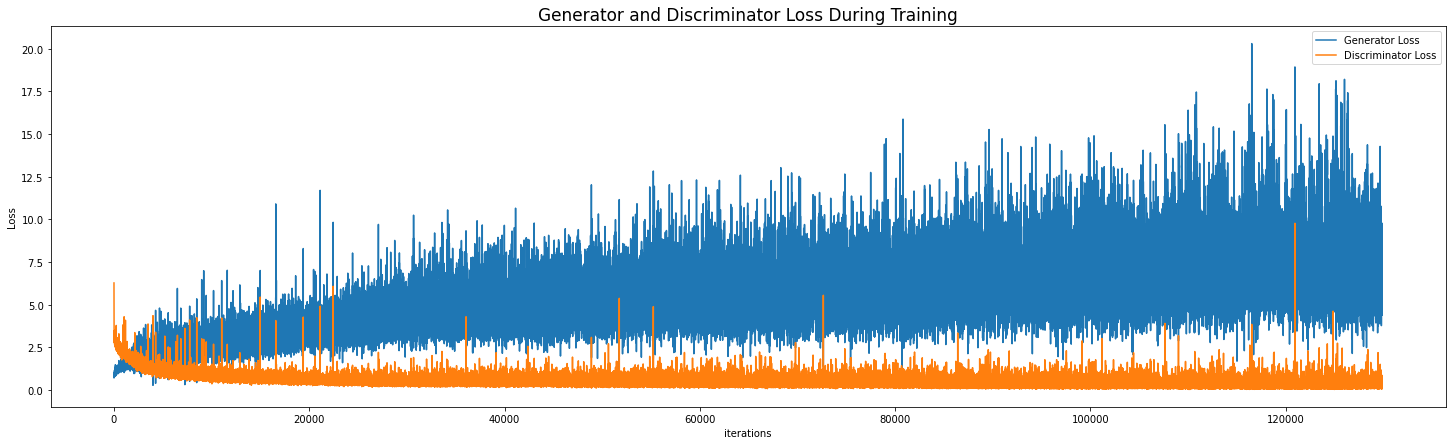

In [15]:
plt.figure(figsize=(25, 7))
plt.title("Generator and Discriminator Loss During Training", fontsize=17)
plt.plot(G_losses,label="Generator Loss")
plt.plot(D_losses,label="Discriminator Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Zip the Result

now i'm zipping the results that we have saved in google colab in order to use them.

In [16]:
!zip -r "/content/ACGAN.zip" "/content/results/cifar10/ACGAN/."

  adding: content/results/cifar10/ACGAN/./ (stored 0%)
  adding: content/results/cifar10/ACGAN/./ACGAN_epoch181.png (deflated 0%)
  adding: content/results/cifar10/ACGAN/./ACGAN_epoch109.png (deflated 0%)
  adding: content/results/cifar10/ACGAN/./ACGAN_epoch315.png (deflated 0%)
  adding: content/results/cifar10/ACGAN/./ACGAN_epoch285.png (deflated 0%)
  adding: content/results/cifar10/ACGAN/./ACGAN_epoch134.png (deflated 0%)
  adding: content/results/cifar10/ACGAN/./ACGAN_epoch267.png (deflated 0%)
  adding: content/results/cifar10/ACGAN/./ACGAN_epoch296.png (deflated 0%)
  adding: content/results/cifar10/ACGAN/./ACGAN_epoch288.png (deflated 0%)
  adding: content/results/cifar10/ACGAN/./ACGAN_epoch188.png (deflated 0%)
  adding: content/results/cifar10/ACGAN/./ACGAN_epoch295.png (deflated 0%)
  adding: content/results/cifar10/ACGAN/./ACGAN_epoch148.png (deflated 0%)
  adding: content/results/cifar10/ACGAN/./ACGAN_epoch012.png (deflated 0%)
  adding: content/results/cifar10/ACGAN/./ACG

# Download Zipped file

in here i'm downloading the file that i have zipped in previous block!

In [17]:
from google.colab import files
files.download("/content/ACGAN.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>